In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
#backend = provider.get_backend("ibmq_jakarta")
from qiskit.test.mock import FakeJakarta

configrc.store_credentials:WARNING:2022-08-01 18:20:20,884: Credentials already present. Set overwrite=True to overwrite.


In [2]:
backend = provider.get_backend("ibmq_jakarta")
#backend = FakeJakarta()

In [3]:
from qiskit import pulse
temp = [1 for i in range(2)]
custom_Pulse_b = []
xval = np.arange(0,2*np.pi,2*np.pi/100)
for x in xval:
    with pulse.build(backend=backend) as custom_Pulse:
            [pulse.play(temp, pulse.drive_channel(0))]
            pulse.delay(10,pulse.drive_channel(0))
            pulse.shift_phase(x,pulse.drive_channel(0))
            [pulse.play(temp, pulse.drive_channel(0))]
    custom_Pulse_b.append(custom_Pulse)

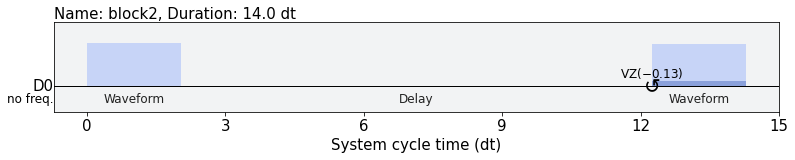

In [9]:
custom_Pulse_b[2].draw()

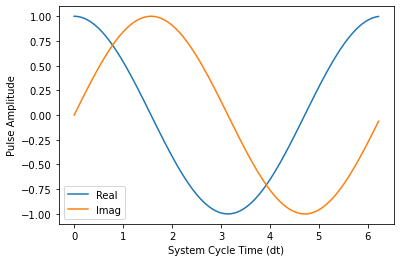

0.9980267284282716


In [4]:
import matplotlib.pyplot as plt
import qiskit.pulse.transforms.canonicalization as canon
from qiskit.pulse import Schedule, Gaussian, Play, ShiftPhase, DriveChannel
from qiskit.visualization.pulse_v2 import device_info, stylesheet
from qiskit.visualization.pulse_v2.events import ChannelEvents
from qiskit.visualization.pulse_v2.generators import gen_filled_waveform_stepwise
drive_chan0 = DriveChannel(0)
real =[]
imag =[]

# Generate waveforms on channel 0
for i_j in custom_Pulse_b:
    chan_events = ChannelEvents.load_program(canon.block_to_schedule(i_j), drive_chan0)
    waveforms = chan_events.get_waveforms()
    line_data_lists = [gen_filled_waveform_stepwise(
                       waveform,
                       formatter=stylesheet.QiskitPulseStyle().formatter,
                       device=device_info.OpenPulseBackendInfo())
                       for waveform in waveforms]

    # Plot the waveforms
   
    for line_data in line_data_lists[2]:
        if line_data.data_type == 'Waveform.Real':
            real.append(line_data.yvals[0])
            if(len(line_data_lists[2]) == 1):
                imag.append(0)
        elif line_data.data_type == 'Waveform.Imag':
            imag.append(line_data.yvals[0])
            if(len(line_data_lists[2]) == 1):
                real.append(0)
plt.figure()        
plt.plot(xval, real, color='C0', label='Real')
plt.plot(xval, imag, color='C1', label='Imag')
plt.xlabel("System Cycle Time (dt)")
plt.ylabel("Pulse Amplitude")
#plt.legend(handles=[real, imag])
plt.legend()
plt.show()
print(line_data_lists[2][0].yvals[0])

In [5]:
def shift_all(circ, traj):
    final = []
    start = 0
    for j,i in enumerate(circ):
        final.append((np.cos(start) + 1j*np.sin(start))*i)
        start+=traj[j]
    return final
        
def parametrize_circ_1(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
                pulse.play(shift_all(circ,traj), pulse.drive_channel(0))
            #pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        batch.append(temp)
    return batch

In [47]:
import pickle
def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

temp = loadData('FGRAFS_controls/FGRAFS-controls_N-160_zero-endpoints-True.p')
temp = temp/np.max(np.abs(temp))
traj = [[(np.pi)/160 for i in range(160)]]
circ = parametrize_circ_1(temp, traj,backend)[0]

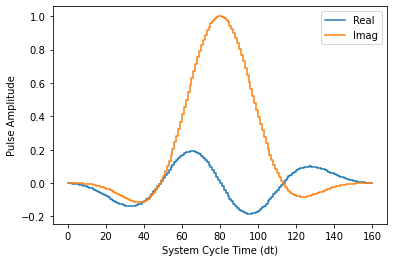

[[LineData(type=Waveform.Real, key=1864796634250438916), LineData(type=Waveform.Imag, key=-4614874036214824804)]]


In [42]:
import matplotlib.pyplot as plt

from qiskit.pulse import Schedule, Gaussian, Play, ShiftPhase, DriveChannel
from qiskit.visualization.pulse_v2 import device_info, stylesheet
from qiskit.visualization.pulse_v2.events import ChannelEvents
from qiskit.visualization.pulse_v2.generators import gen_filled_waveform_stepwise

# Generate waveforms on channel 0
chan_events = ChannelEvents.load_program(canon.block_to_schedule(circ), drive_chan0)
waveforms = chan_events.get_waveforms()
line_data_lists = [gen_filled_waveform_stepwise(
                   waveform,
                   formatter=stylesheet.QiskitPulseStyle().formatter,
                   device=device_info.OpenPulseBackendInfo())
                   for waveform in waveforms]

final = [] 
real= []
imag = []
temp= []
# Plot the waveforms
plt.figure()
for line_data_list in line_data_lists:
    for line_data in line_data_list:
        if line_data.data_type == 'Waveform.Real':
            real, = plt.plot(line_data.xvals, line_data.yvals, color='C0', label='Real')
        elif line_data.data_type == 'Waveform.Imag':
            imag, = plt.plot(line_data.xvals, line_data.yvals, color='C1', label='Imag')
plt.xlabel("System Cycle Time (dt)")
plt.ylabel("Pulse Amplitude")
plt.legend(handles=[real, imag])
plt.show()
print(line_data_lists)

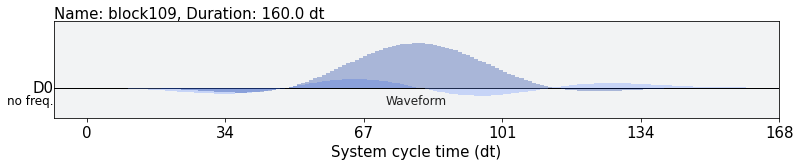

In [43]:
circ.draw()

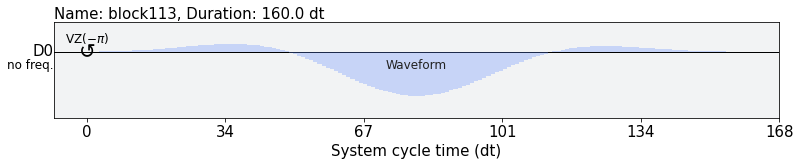

In [48]:
with pulse.build(backend=backend) as c:
        pulse.shift_phase(np.pi,pulse.drive_channel(0))    
        pulse.play(temp, pulse.drive_channel(0))
c.draw()

In [1]:
chan_events = ChannelEvents.load_program(canon.block_to_schedule(c), drive_chan0)
waveforms = chan_events.get_waveforms()
line_data_lists = [gen_filled_waveform_stepwise(
                   waveform,
                   formatter=stylesheet.QiskitPulseStyle().formatter,
                   device=device_info.OpenPulseBackendInfo())
                   for waveform in waveforms]

final = [] 
real= []
imag = []
temp= []
# Plot the waveforms
plt.figure()
for line_data_list in line_data_lists:
    for line_data in line_data_list:
        if line_data.data_type == 'Waveform.Real':
            real, = plt.plot(line_data.xvals, line_data.yvals, color='C0', label='Real')
        elif line_data.data_type == 'Waveform.Imag':
            imag, = plt.plot(line_data.xvals, line_data.yvals, color='C1', label='Imag')
plt.xlabel("System Cycle Time (dt)")
plt.ylabel("Pulse Amplitude")
#plt.legend(handles=[real, imag])
plt.show()
print(line_data_lists)

NameError: name 'ChannelEvents' is not defined